# Ultrasound Diffraction Lab

This notebook contains interactive content. Click __Cell &#x21e8; Run All__ to enable it.

## Table of contents

0. [Helper Functions](#Helper-functions)
0. [Units](#Units)
0. [(1) AC & DC Multimeter Readings](#multimeter)
0. [(2) Processing the Data](#Processing-the-Data)
    0. [Convert Potentiometer Voltages to Angles](#Interpolation-of-Noise-Floor)
    0. [Remove Vertical and Horizontal Offset of Data](#Remove Vertical and Horizontal Offset of Data)
    0. [Process each data set](#Process each data set)
    0. [Intensity versus Θ plots](#intensityvplots)
0. [(3) Theoretical Comparison](#theor)
    0. [Wavelength of Sound](#)
    0. [Theoretical $A^2$ Expression](#)
    0. [Calculation of $A^2_N$, Plots of Intensity vs. Angle](#)
    0. [Agreement/Differences between experiment and theoretical curves](#)
0. [(4) Comparison of single slit data and noise data](#)
    0. [Plot Amplitude versus Θ for single slit and noise data](#)


In [1]:
import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 7)
plt = matplotlib.pyplot

import scipy.constants as constants
import scipy.interpolate as interpolate

import ipywidgets as widgets

from IPython.display import Markdown, Latex

import sympy
sympy.init_printing()

## Helper functions

In [2]:
def csv_to_array(filename):
    """
    Read data from a comma-separated-value file
    into a 2D NumPy array.
    """
    f = open(filename, 'rb')
    return np.loadtxt(f, delimiter=',')

def quadtrature(*values):
    """
    Add all of the arguments in quadtrature, element-wise.
    """
    np.power(values, 2)
    return np.sqrt(np.sum(np.power(values, 2),axis=0))

def amplitude_to_intensity(data):
    """
    Convert a 2d array of angle-amplitude-error data into
    angle-intensity-error data.
    """
    intense_data = data.copy()
    # Square the value
    intense_data[:,1] **= 2
    # Handle the error
    intense_data[:,2] = 2 * data[:,2]/data[:,1] * intense_data[:,1]

    return intense_data

def clip_array(data, to_bounds_of):
    """
    Clips the data in the 2D array, "data", where the x-values
    fall outside the range of the x-values of "to_bounds_of".
    Assumes "to_bounds_of" is ordered smallest-to-largest.
    """
    # Return elements of data where...
    return data[
        # The elements meet both of the folling conditions...
        np.logical_and(
            # The x-values are greater than the smallest x-value in to_bounds_of
            to_bounds_of[0,0] < data[:,0],
            # The x-values are less than the biggest x-value in to_bounds_of
            data[:,0] < to_bounds_of[-1,0]
        )
    ]

def print_formula(*sympy_expressions):
    """
    Display sympy experissions in a Jupyter notebook,
    even if it's not the last value in a cell.
    """
    return Latex('$$'+'\;\;\;\;'.join(map(lambda x: sympy.latex(x), sympy_expressions))+'$$')

## Units
Define a few units used throughout for the sake of clarity.

In [3]:
m = 1.0
cm = 1e-2
mm = 1e-3
Hz = 1.0
volts = 1.0
degree = constants.pi/180.0
degrees_c = 1.0

## Recorded Data

In [4]:
# Distance to between the middle of turntable to the receiver
distance = 223.5*cm
distance_d = 1*cm

frequency = 40010*Hz
frequency_d = 2*Hz

# Distance between the middle of the turntable and the front
# of the diffraction grating.
distance_2 = 11*cm
distance_2_d = 0.5*cm

perpendicular = -10 * degree
perpendicular_d = 1 * degree

lab_temperature = 24.2*degrees_c
lab_temperature_d = 0.2*degrees_c

slat_width = 2.1*cm
slat_width_d = 1.0*mm

slit_width = 1.1*cm
slit_width_d = 1.0*mm

angle_rads_voltage_data = np.array([
    [3.09867*volts, -30*degree],
    [2.70056*volts,   0*degree],
    [2.29335*volts,  30*degree],
])

# Import csv data into NumPy arrays
data_noise_raw  = csv_to_array(r'./noise.csv')
data_1_slit_raw = csv_to_array(r'./1slit.csv')
data_2_slit_raw = csv_to_array(r'./2slits.csv')
data_4_slit_raw = csv_to_array(r'./4slits.csv')
data_6_slit_raw = csv_to_array(r'./6slits.csv')

Markdown('Imported {} data points sucessfully.'.format(
    len(data_noise_raw)+
    len(data_1_slit_raw)+
    len(data_2_slit_raw)+
    len(data_4_slit_raw)+
    len(data_6_slit_raw)
))

Imported 1245 data points sucessfully.

The imported data is placed in a matrix like:
~~~~~~
[[xvalue, yvalue],
 [xvalue, yvalue],
 ...
 [xvalue, yvalue]]
~~~~~~
We access the x-values, and y values like so:
~~~~~~
Xs = data[:,0]
Ys = data[:,1]
~~~~~~
We will also add another column, yerr:
~~~~~~
Y_err = data[:,2]
~~~~~~

## (1) AC & DC Multimeter Readings
It is possible to record both measuments using the same multimeter because the receiver signal is AC, and the turntable position is DC. The computer just needs to instruct the multimeter to perform an AC root-mean-squared voltage reading for the amplitude, and then instruct the multimeter to perform a DC averaged voltage reading for the turntable position.

## (2) Processing the Data

### Convert Potentiometer Voltages to Angles
The voltages from the turntable potentiometer for three angles were recorded. The potentiometer is linear, so a simple linear relationship can be constructed:

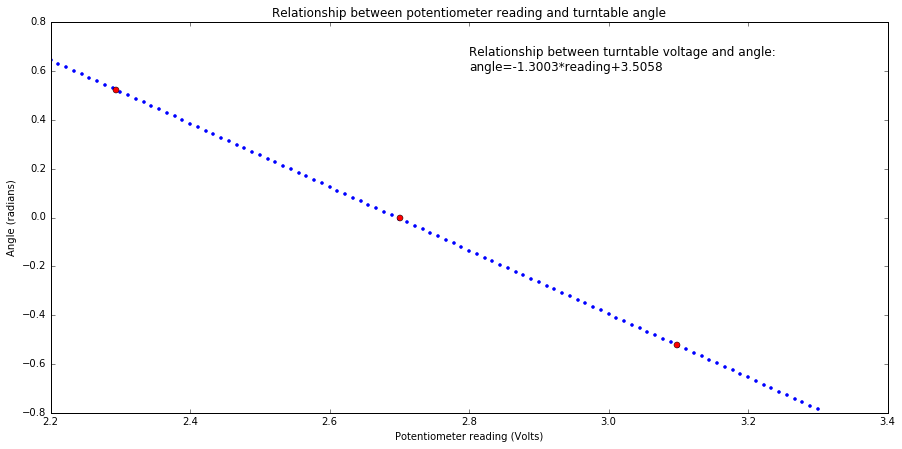

In [6]:

# The potentiometer in the turn-table is linear,
# so we can just come up with a constant to
# multiply readings with to convert them to rads.

# slope = rise/run
slope = ((angle_rads_voltage_data[-1,1] - angle_rads_voltage_data[0,1] ) /
         (angle_rads_voltage_data[-1,0] - angle_rads_voltage_data[0,0] ))

# offset = angle-slope*reading
offset = angle_rads_voltage_data[-1,1] - slope*angle_rads_voltage_data[-1,0]



def voltage_to_radians(reading_Volts):
    """
    Convert a voltage reading from the turn-table
    into an angle in radians
    """
    return slope*reading_Volts+offset

x = np.linspace(2.2, 3.3, 100)
y = voltage_to_radians(x)
plt.title('Relationship between potentiometer reading and turntable angle')
plt.ylabel('Angle (radians)')
plt.xlabel('Potentiometer reading (Volts)')
plt.plot(x, y, 'b.')
plt.plot(angle_rads_voltage_data[:,0], angle_rads_voltage_data[:,1], 'ro');
plt.text(2.8, 0.6, 'Relationship between turntable voltage and angle:\n'+
                   'angle={:.4f}*reading{:+.4f}'.format(slope,offset), fontsize=12);

### Remove Vertical and Horizontal Offset of Data
To ensure the plots are offset an appropriate amount to bring the data to zero, the data from the 0-slit experiment can be used to establish a baseline noise-floor that can be subtracted from the other results. This serves to reduce systematic error in the readings caused by background noise.
In order to subtract this noise-floor, a continuous function interpolated from the data must be constructed, since the
x-values in the noise-floor readings don't necessarily match the x-values of the signal readings.
A Univariate Spline function is used to interpolate the data.

The angle between 0 degrees on the turntable and the highest intensity observed was recorded as `perpendicular`. Subtracting this value from the $\Theta$ values in the data sets centers the data horizontally.

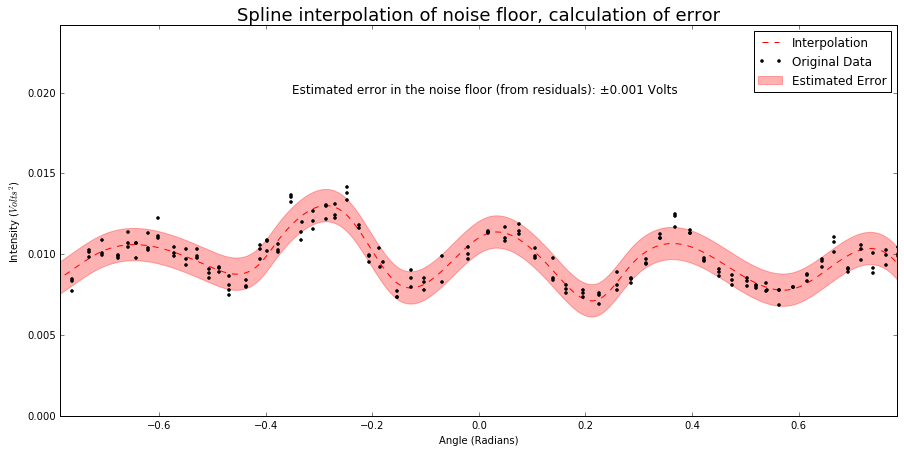

In [7]:
data_noise = data_noise_raw.copy()
# Convert turntable potentiometer readings to radians
data_noise[:,0] = voltage_to_radians(data_noise_raw[:,0])
# We also had an offset on the angle of our system,
# i.e. 0deg was not the max amplitude. Subtract this difference:
data_noise[:,0] = data_noise[:,0] - perpendicular
# Convert from amplitude to intensity
data_noise[:,1] = data_noise[:,1]**2

# This smoothing factor is applied to the spline interpolation
smoothing_factor = 1*1e-4

# Do the interpolation
noise_interp = interpolate.UnivariateSpline(
    # X-values
    data_noise[:,0],
    # Y-values
     data_noise[:,1]
)
noise_interp.set_smoothing_factor(smoothing_factor)

# Also interpolate the error
noise_interp_err = interpolate.UnivariateSpline(
    # X-values
    data_noise[:,0],
    # Y-values
    np.ones(len(data_noise[:,0]))*noise_interp.get_residual()*10,
)
noise_interp_err.set_smoothing_factor(smoothing_factor)

# And now show the continuous interpolation
x_values = np.linspace(data_noise[0,0], data_noise[-1,0], 500)
plt.plot(x_values, noise_interp(x_values), 'r--', label='Interpolation');
# And here's a plot of the errors, also continuous
plt.fill_between(
    x_values,
    noise_interp(x_values)-noise_interp_err(x_values),
    noise_interp(x_values)+noise_interp_err(x_values),
    color='red',
    alpha=0.3,
    label='Estimated Error'
)
# And now overlay the original data
plt.plot(data_noise[:,0], data_noise[:,1], 'k.', label='Original Data')
plt.title('Spline interpolation of noise floor, calculation of error', fontsize=18)
plt.ylabel('Intensity ($Volts^2$)')
plt.xlabel('Angle (Radians)')
plt.ylim(0, np.max(data_noise[:,1])+0.01);
plt.xlim(-constants.pi/4, constants.pi/4);
plt.legend()
plt.text(-0.35, 0.02,
         'Estimated error in the noise floor (from residuals): ±{:.3f} Volts'.format(
        noise_interp.get_residual()*10
    ), fontsize=12)
plt.show();

### Process each data set
Now each data set must be processed in the following ways:
- Convert the reading from the turntable potentiometer into radians
- Subtract the perpendicular angle, so that the readings will be centered at 0
- Clip the data set to the bounds of the noise floor
- Remove the noise from the data set
- Convert amplitude to intensity
- Adjust the error of each data point accodingly

In [8]:
def process_data(data_raw):
    
    len_v, len_h = np.shape(data_raw)
    data = np.ndarray((len_v, len_h+1))
    data[:,[0,1]]=  data_raw.copy()
    
    # Convert the voltage readings from the turn-table
    # potentiometer into radians
    data[:,0] = voltage_to_radians(data[:,0])
    
    # We also had an offset on the angle of our system,
    # i.e. 0deg was not the max amplitude. Subtract this difference:
    data[:,0] = data[:,0] - perpendicular
    
    # Clip the data to the farthest extents of the noise floor
    data = clip_array(data, to_bounds_of=data_noise)
    
    # Subtract the interpolated noise floor from the readings
    data[:,1] = data[:,1]-noise_interp(data[:,0])
    
    # And adjust the error accordingly
    data[:,2] = noise_interp_err(data[:,0])
    # Convert from amplitude to intensity and handle error propagation
    data = amplitude_to_intensity(data)
    
    return data


data_1_slit = process_data(data_1_slit_raw)
data_2_slit = process_data(data_2_slit_raw)
data_4_slit = process_data(data_4_slit_raw)
data_6_slit = process_data(data_6_slit_raw)

### Intensity versus $\Theta$ plots

Plot of intensity versus $\Theta$ for each data set.

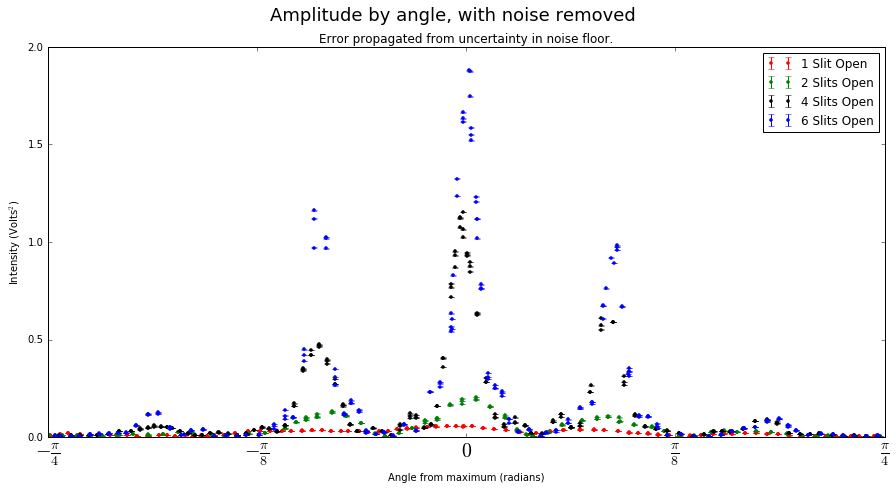

In [9]:
# Use the following tick marks on the plots, instead of radians in decimals
ticks = [-sympy.pi/4, -sympy.pi/8, 0, sympy.pi/8, sympy.pi/4]

fig = plt.figure()
ax  = fig.add_subplot(111)

# Get the latex corresponding to each of those ticks, use as labels
y_label = ['$'+sympy.latex(t)+'$' for t in ticks]
ax.set_xticklabels(y_label, fontsize=20)
# Get the float corresponding to each of those ticks
ax.set_xticks([sympy.N(t) for t in ticks])


def plot_data(data, fmt, label):
    ax.errorbar(data[:,0], data[:,1], data[:,2], fmt=fmt, label=label)

plot_data(data_1_slit, 'r.', '1 Slit Open')
plot_data(data_2_slit, 'g.', '2 Slits Open')
plot_data(data_4_slit, 'k.', '4 Slits Open')
plot_data(data_6_slit, 'b.', '6 Slits Open')

fig.suptitle('Amplitude by angle, with noise removed', fontsize=18)
ax.set_title(
    'Error propagated from uncertainty in noise floor.',
    fontsize=12
)
ax.set_xlabel('Angle from maximum (radians)')
ax.set_ylabel('Intensity (Volts$^2$)')
ax.set_ylim(0)
ax.set_xlim(float(ticks[0]), float(ticks[-1]))
ax.legend();


<br>
<br>
<br>




## (3) Theoretical Comparison

### Wavelength of Sound
The theortical model requires $\lambda$, the wavelength of the ultrasound used in the experiment. This value is calculated from the the lab temperature and the sound frequency using the equation:

In [10]:
(
    pm,
    T,
    sigma_T,
    f,
    sigma_f
) = sympy.symbols('± T sigma_T f sigma_f')

speed_of_sound = 331.4 + 0.6 * T
wavelength = speed_of_sound / f
wavelength_d = sympy.sqrt(
    (sympy.diff(wavelength, T)*sigma_T)**2+
    (sympy.diff(wavelength, f)*sigma_f)**2
)

print_formula(wavelength, pm, wavelength_d)

<IPython.core.display.Latex object>

Now calculate the value and uncertainty:

In [11]:
wavelength = wavelength.evalf(subs={
        T: lab_temperature,
        f: frequency
    })

wavelength_d = wavelength_d.evalf(subs={
        T: lab_temperature,
        sigma_T: lab_temperature_d,
        f: frequency,
        sigma_f: frequency_d,
    })

Markdown(
    'The wavelength of the sound in the lab was: {:.3e} $\pm$ {:.0e}'
    .format(wavelength, wavelength_d)
)

The wavelength of the sound in the lab was: 8.646e-3 $\pm$ 3e-6

### Theoretical $A^2$ Expression
Create a symbolic equation for the theoretical model using SymPy, and convert that equation so that it can operate on vectors.

In [12]:
(
    dist_1,
    dist_2,
    b,
    d,
    N,
    intensity_expr,
    intensity_expr_d,
    Lambda,
    theta,
    n
) = sympy.symbols('d_1 d_2 b d N A_n^2 A_d lambda theta n')

# b= slit_wdith
# d= slat width
# Beta = 
# N= number of slits open
# A^2_n = experimental constant = intensity_expr
k = 2*sympy.pi/Lambda
beta = k*d*sympy.sin(theta)
phi = k*b*sympy.sin(theta)

Intensity = intensity_expr * (
    (sympy.sin(phi/2)*sympy.sin(N*beta/2))/
    ((phi/2)*sympy.sin(beta/2))
)**2;


dI_db = sympy.diff(Intensity, b)
dI_dd = sympy.diff(Intensity, d)
dI_dlambda = sympy.diff(Intensity, Lambda)
dI_dAsquaredN = sympy.diff(Intensity, intensity_expr)
Intensity_err = sympy.sqrt(
    (dI_db*slit_width_d)**2+
    (dI_dd*(slat_width_d+slit_width_d))**2+
    (dI_dlambda*wavelength_d)**2+
    (dI_dAsquaredN*intensity_expr_d)
)

# Substitute in values for slit and slat width
replaced = Intensity.subs({
    b: slit_width,
    d: slat_width+slit_width,
    Lambda: wavelength
})

# Convert to a NumPy equation
fast = sympy.lambdify((theta, N, intensity_expr), replaced, "numpy")

# Substitute in values for slit and slat width
replaced_err = Intensity_err.subs({
    b: slit_width,
    d: slat_width+slit_width,
    Lambda: wavelength,
})

# Convert to a NumPy equation
fast_err = sympy.lambdify((theta, N, intensity_expr, intensity_expr_d), replaced_err, "numpy")

Markdown('The expanded equation for intensity is:\n\n $$'+ sympy.latex(Intensity)+'$$')

The expanded equation for intensity is:

 $$\frac{A^{2}_{n} \lambda^{2} \sin^{2}{\left (\frac{\pi b}{\lambda} \sin{\left (\theta \right )} \right )} \sin^{2}{\left (\frac{\pi N}{\lambda} d \sin{\left (\theta \right )} \right )}}{\pi^{2} b^{2} \sin^{2}{\left (\theta \right )} \sin^{2}{\left (\frac{\pi d}{\lambda} \sin{\left (\theta \right )} \right )}}$$

In [13]:

maxima_pos = sympy.asin(n*Lambda/d)


dm_dd = sympy.diff(maxima_pos, b)
dm_dlambda = sympy.diff(maxima_pos, Lambda)
maxima_pos_err = sympy.sqrt(
    (dm_dd*(slat_width_d+slit_width_d))**2+
    (dm_dlambda*wavelength_d)**2
)

# Substitute in values for slit and slat width
replaced = maxima_pos.subs({
    d: slat_width+slit_width,
    Lambda: wavelength
})

# Convert to a NumPy equation
fast_maxima_pos = sympy.lambdify((n), replaced, "numpy")

# Substitute in values for slit and slat width
replaced_err = maxima_pos_err.subs({
    d: slat_width+slit_width,
    Lambda: wavelength,
})

# Convert to a NumPy equation
fast_maxima_err = sympy.lambdify((n), replaced_err, "numpy")

Markdown('The expanded equation for intensity is:\n\n $$'+ sympy.latex(maxima_pos)+'$$')

The expanded equation for intensity is:

 $$\operatorname{asin}{\left (\frac{\lambda n}{d} \right )}$$

### Calculation of $A^2_N$, Plots of Intensity vs. Angle
- calculate $A^2_N$ from each data set
- Plot the intensity data and model with error bars and residuals.
- Plot error on of model

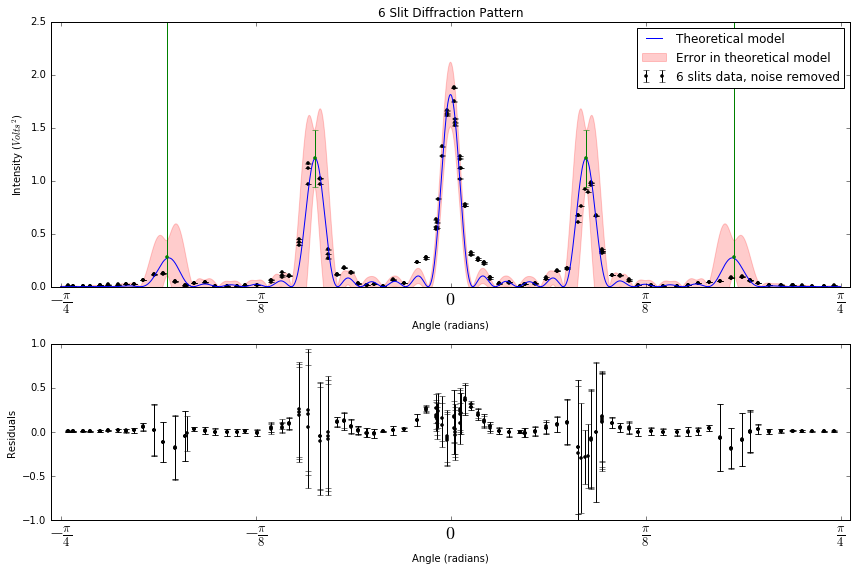

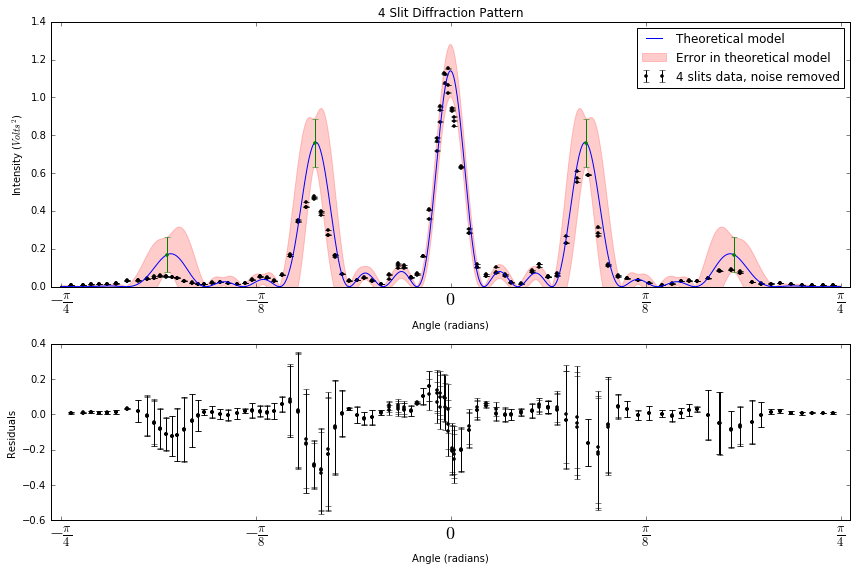

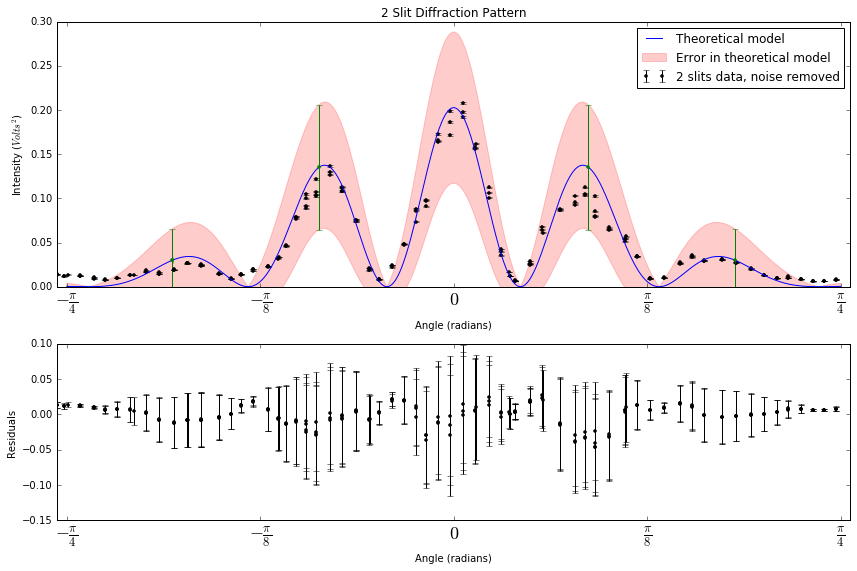

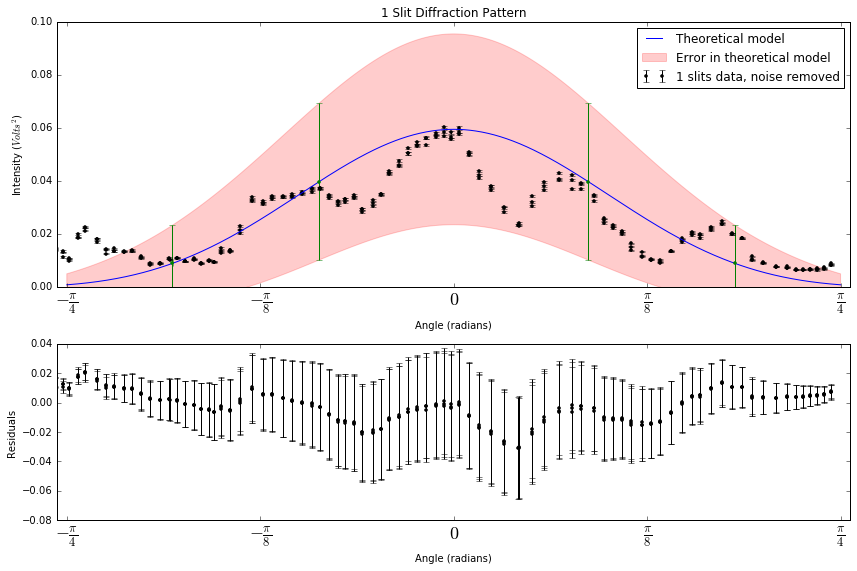

In [14]:

# Use a range from -pi/4 to +pi/4, but avoid 0.
theta_vals = np.linspace(-np.pi/4, np.pi/4, 1000)
theta_vals = np.delete(theta_vals, np.where(theta_vals==0))

# Gridspec for showing the main charts and residuals
gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[3, 2])

# Loop through each data set, assign the number of slits open to N
for N, data in zip((6,4,2,1), (data_6_slit, data_4_slit, data_2_slit, data_1_slit)):
    
    # Get A_N^2 by taking the maximum intensity value, dividing by the number of slits.
    # Use the mean of a few values around the maximum as the maximum value
    # Also need to propagate the error from the maximum intensity valeue
    max_ii = np.argmax(data[:,1])
    max_values = data[max_ii-1:max_ii+1,1]
    max_vals_averaged = np.mean(max_values)
    max_vals_err = np.std(data[max_ii-1:max_ii+1,1], ddof=1)
    
    a_squared_n = max_vals_averaged/N**2
    a_squared_n_d = (1/N**2)*max_vals_err # propagate error
    
    # Calculate the theoretical curve
    YYY = fast(theta_vals, N, a_squared_n)
    # And the residuals
    YYY_res = fast(data[:,0], N, a_squared_n)
    
    # This is the error on the theoretical curve
    error_eqn = fast_err(theta_vals,  N, a_squared_n, a_squared_n_d)
    
    fig = plt.figure(figsize=(12,8))
    ax  = fig.add_subplot(gs[0])
    
    # Use symbols for angle
    y_label = ['$'+sympy.latex(t)+'$' for t in ticks]
    ax.set_xticks([sympy.N(t) for t in ticks])
    ax.set_xticklabels(y_label, fontsize=18)
    ax.set_xlim(-np.pi/4-0.02, np.pi/4+0.02)
    
    # Plot the data with error bars
    ax.errorbar(data[:,0],
                data[:,1],
                data[:,2],
                fmt='k.',
                label='{} slits data, noise removed'.format(N))
    
    # And plot the error in the theoretical model using an area plot
    ax.fill_between(
        theta_vals,
        YYY-np.abs(error_eqn),
        YYY+np.abs(error_eqn),
        color='red',
        alpha=0.2,
        label='Error in theoretical model'
    )
    ax.plot(theta_vals, YYY, 'b', label='Theoretical model')
    ax.legend()
    ax.set_title('{} Slit Diffraction Pattern'.format(N))
    ax.set_xlabel('Angle (radians)')
    ax.set_ylabel('Intensity ($Volts^2$)')
    ax.set_ylim(0)
    
    # Peak position error bars
    n_vals = np.array([-2,-1,1,2])
    theta_max = fast_maxima_pos(n_vals)
    ax.errorbar(theta_max,
                fast(theta_max, N, a_squared_n),
                xerr=fast_maxima_err(n_vals),
                yerr=fast_err(theta_max,  N, a_squared_n, a_squared_n_d),
                fmt='g.')
    
    # Now create the residuals plot
    ax  = fig.add_subplot(gs[1])
    
    # Symbolic x-ticks
    ax.set_xticks([sympy.N(t) for t in ticks])
    ax.set_xticklabels(y_label, fontsize=18)
    ax.set_xlim(-np.pi/4-0.02, np.pi/4+0.02)
    
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Angle (radians)')
    
    ax.errorbar(
        
        data[:,0],
        
        # Y position is the difference between the data
        # values and the theoretical result
        data[:,1]-YYY_res,
        
        # The error in the residuals is the error in the model,
        # and the error in the data, added in quadrature:
        quadtrature(data[:,2], fast_err(data[:,0], N, a_squared_n, a_squared_n_d)),
        
        fmt='k.',
        label='{} slits'.format(N)
    )
    
    fig.tight_layout()
    plt.show()
    print("\n\n")

### Agreement/Differences between experiment and theoretical curves

There is good agreement between the experimental data and the theoretical results. The residuals are spread evenly above and below 0 and almost all of the residuals have error bars that extend to zero. The data set with the largest differences between experiment and theory is the 4 slit experiment, where the secondary peaks are of lower than expected amplitude. 



<br>
<br>
<br>

## (4) Comparison of single slit data and noise data

### Plot Amplitude versus $\Theta$ for single slit and noise data

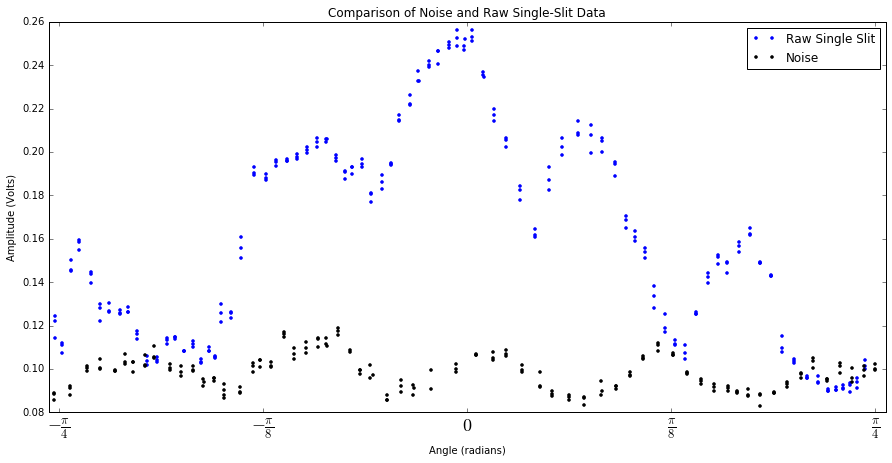

In [16]:

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title('Comparison of Noise and Raw Single-Slit Data')
ax.plot(
    voltage_to_radians(data_1_slit_raw[:,0])-perpendicular,
    data_1_slit_raw[:,1],
    'b.',
    label='Raw Single Slit'
)
ax.plot(data_noise[:,0], np.sqrt(data_noise[:,1]), 'k.', label='Noise')
ax.legend()

# Use symbols on x-axis
y_label = ['$'+sympy.latex(t)+'$' for t in ticks]
ax.set_xticks([sympy.N(t) for t in ticks])
ax.set_xticklabels(y_label, fontsize=18)

ax.set_xlim(-np.pi/4-0.02, np.pi/4+0.02)
ax.set_xlabel('Angle (radians)');
ax.set_ylabel('Amplitude (Volts)');


There does appear to be some correlation between the single-slit data and the noise floor. On the left half of the data, the peaks and throughs somewhat lined up. On the right half though, the opposite appears to be the case.
The cause of this correlation may be that the material covering the slits in the diffraction grating is not fully opaque to ultrasound; this could create a diffraction patttern even when no, or most, slits are covered.

The two data sets may also be related by the geometry of the lab, e.g. it could be that there is some of the sound is reflecting off other objects in the lab and causing spurious readings that vary with angle.

In the analysis of this lab, the noise data was subtracted from the signal data, so any systematic angle-varying effect on intensity should be removed, as long as it did not change between capturing the noise data and the signal data.